# ANALISIS DE RIESGOS: Crew

En este notebook se crea un modelo para el PHA dadas las caracteristicas de la tripulación.

In [1]:
#  Manejo de datos
import pandas as pd

#  Análisis de datos
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelado
from pycaret.classification import *
import xgboost

#  Auxiliares
# Fecha y hora
from datetime import datetime
#  Numéricos
import numpy as np
#  Texto
import re
# Uso de modelos
import joblib

#  Representaciones gráficas
#  Graficos
import matplotlib.pyplot as plt
#  Mapas
import geopandas
import folium
from folium import plugins



#Correalicion entre variables
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#Imputación
from sklearn.impute import KNNImputer
import codecs
import pandas as pd
import pyarrow.parquet as pq

# Auxiliares
import numpy as np
import logging
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.tree import DecisionTreeRegressor

## OBTENCIÓN DE DATOS

A continuación se carga en un dataframe los datos extraídos de la fuente de estudio guardados en formato parquet por su gran volumen de datos.

In [2]:
# Directorio de los datos
data_dir = 'Datasets/PHA/'
pha_file = 'PHA_Data.parquet'
legend_file = 'column_info.csv'
model_info_dir = 'Crew/'

In [3]:
# Lectura del fichero .parquet creado todo el conjunto de datos
data_df = pd.read_parquet(data_dir + pha_file, engine='pyarrow')

# Dataframe y diccionario leyenda de las columnas
df_legend = pd.read_csv(data_dir + legend_file)
leyend_dict = dict(zip(df_legend['Column_name'], df_legend['Description']))

In [4]:
df_legend

,Column_name,Description
0,c5,Unique control number used to relate to AID_MA...
1,c1,Type of Event
2,c2,FAR part number
3,c3,Form on which the latest data was received.
4,c4,Agency conducting investigation.
...,...,...
174,c163,2nd Additional cause factor text
175,c183,Supporting Factor Text ...
176,c191,Supporting cause factor B text. O...
177,c229,Date of Birth of PIC


In [5]:
data_df

,c1,c6,c7,c8,c10,c132,c134,c136,c138,c141,...,c150,c154,c156,c158,c161,c163,c183,c191,c229,c230
0,A,1975,1,1,None,None,None,None,None,None,...,POWERED,None,None,None,None,None,None,None,NaN,NaN
1,A,1975,1,1,None,None,None,None,None,None,...,POWERED,None,None,Wheeled-Tricycle,None,None,None,None,NaN,NaN
2,A,1975,1,1,None,None,None,None,None,None,...,POWERED,None,None,Wheeled-Tricycle,None,None,None,None,NaN,NaN
3,A,1975,1,1,None,None,None,None,None,None,...,POWERED,None,None,Wheeled-Tricycle,None,None,None,None,NaN,NaN
4,A,1975,1,1,None,None,None,None,None,None,...,POWERED,None,None,None,None,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214659,I,2022,2,6,1710,None,None,None,None,None,...,None,None,None,Wheeled-Tricycle,None,None,None,None,19700731.0,NaN
214660,I,2022,2,7,1505,None,None,None,None,None,...,POWERED,None,None,Wheeled-Tricycle,None,None,None,None,19600615.0,NaN
214661,I,2022,1,31,0832,None,None,None,None,None,...,None,None,None,Wheeled-Tricycle,None,None,None,None,19810601.0,19980409.0
214662,I,2022,1,7,0407,None,None,None,None,None,...,None,None,None,Wheeled-Tricycle,None,None,None,None,19520606.0,NaN


## EXPLORATORY DATA ANALYSIS (EDA)

<h4><div style="font-size:14px; text-align:center"><b>REDUCCIÓN DE DIMENSIONALIDAD</b><br></div></h4>

Dado que el numero de columnas es elevado y alguna de estas no aporta información a nuestro caso de estudio, se realiza primero la selección de los atributos de estudio dejando así un dataframe que sea más reducido en cuanto a sus atributos de partida para poder trabajar el analisis de datos con mayor facilidad.

<h5><div style="font-size:14px; text-align:left"><b>1.Multicolinealidad:</b><br></div></h5>

Si las variables predictoras tienen una alta correlación entre sí, puede haber problemas de multicolinealidad. La multicolinealidad ocurre cuando hay una fuerte relación lineal entre las variables independientes, lo que puede dificultar la interpretación de los coeficientes del modelo y conducir a estimaciones inestables. En tales casos, puede ser deseable eliminar una de las variables correlacionadas o combinarlas para crear una nueva variable

También es importante la interpretación y simplicidad; una alta correlación entre las variables predictoras puede dificultar la interpretación de los resultados. En ese caso, puede ser preferible trabajar con variables menos correlacionadas para facilitar la comprensión de cómo cada una afecta a la variable objetivo.</p>

<p>Como primer estudio para ver la relación de los datos y ayudarnos a tomar la decisión de los atributos a seleccionar, se observa la relación de las columnas de forma gráfica. Esto es, la dependencia que tiene una columna con repecto a las otras si estas varian.</p>
<p>Para este estudio, se emplea el metodo <i>corr</i> de Pandas. Pero, previamente se requiere codificar las variables no numéricas ya que esta función, únicamente actúa sobre las columnas numéricas, y es este momento, queremos ver la relación de todas las columnas. Para ello, se hace uso del modulo <i>preprocessing</i> de <b>scikit-learn</b>. Con este modulo se puede hacer uso de métodos que nos permitirá codificar los atributos categóricas a numéricos.<br>
    Se utiliza el encoder <b>OrdinalEncoder</b> que transforma el valor en el ordinal para la columna, dando como resultado valores numericos de 0 a n-1 caracterisitica.</p>

In [6]:
# Instancia del codificador
oe = OrdinalEncoder()

# Ajuste del modelo (fit) y codificación de los datos (transform)
oe.fit(data_df)
data_encoded = oe.transform(data_df)

# Crear un dataframe auxiliar con los atributos y valores transformados
names = oe.get_feature_names_out()
df_encoded = pd.DataFrame(data_encoded, columns=names)
df_encoded

,c1,c6,c7,c8,c10,c132,c134,c136,c138,c141,...,c150,c154,c156,c158,c161,c163,c183,c191,c229,c230
0,0.0,1.0,0.0,0.0,1937.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,13.0,33.0,33.0,1.0,1.0,NaN,NaN
1,0.0,1.0,0.0,0.0,1937.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,NaN,NaN
2,0.0,1.0,0.0,0.0,1937.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,NaN,NaN
3,0.0,1.0,0.0,0.0,1937.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,NaN,NaN
4,0.0,1.0,0.0,0.0,1937.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,13.0,33.0,33.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214659,3.0,48.0,1.0,5.0,1100.0,26.0,17.0,26.0,14.0,9.0,...,3.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,5275.0,NaN
214660,3.0,48.0,1.0,6.0,967.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,3582.0,NaN
214661,3.0,48.0,0.0,30.0,519.0,26.0,17.0,26.0,14.0,9.0,...,3.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,6608.0,1257.0
214662,3.0,48.0,0.0,6.0,251.0,26.0,17.0,26.0,14.0,9.0,...,3.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,2107.0,NaN


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Atributos mapeados a numéricos</i></div>

In [7]:
corr = df_encoded.corr()
#corr.style.background_gradient(cmap='Blues')

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Matriz de correlacion de atributos.</i></div>

In [8]:
# Eliminar la diagonal principal y los valores debajo de esta, manteniendo solo los valores superiores
# para ver solo valores unicos diferentes de 1 (relacion con diferentes atributos)
corr_filter = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))

# Ordenar de mayor a menor
corr_sort = corr_filter.stack().sort_values(ascending=False).to_frame()

# Añadir nombres a las columnas para entender las relaciones
corr_sort = corr_sort.rename(columns=leyend_dict, index=leyend_dict)

corr_sort.head(60)

0
Including crew and passengers.                     Number of passengers onboard                        0.999322
Region of the air operator                         District office of the air operator                 0.994042
Region of the accident/incident location.          District office of the accident/incident location.  0.986830
Code for Weight  Class                             Powered, Nonpowered, Optional                       0.969616
Under or over 750 hp.                              Type of engine.                                     0.967706
Type of the engine code.                           Piston, turbine, turboprop, etc.                    0.960989
Residence region code of the pilot in command      Residence district office code of the pilot in ...  0.958168
Under or over 750 hp.                              Type of the engine code.                            0.951808
Type of the engine code.                           Type of engine.                                     0.947604
                                                   Text for element C153.                              0.940691
Latitude coordinates of the accident/incident      Longitude coordinates of the accident/incident      0.939748
Second remedial action area code                   Second remedial action area text                    0.938856
                                                   Second remedial action taken code                   0.932946
Number of passengers injured                       All injuries including crew passengers and public.  0.929659
Second persons involved code                       Supporting cause factor B code.            OPER...  0.926073
Number of passengers killed                        Total Fatalities                                    0.924392
Second remedial action taken code                  Second remedial action area text                    0.921989
Persons involved code                              Supporting cause factor A code.            OPER...  0.918476
Piston, turbine, turboprop, etc.                   Type of engine.                                     0.913665
Under or over 750 hp.                              Piston, turbine, turboprop, etc.                    0.913075
Second persons involved code                       Second contributing factor text                     0.906583
Code for Aircraft Design                           Wing information of the aircraft involved in th...  0.900926
Piston, turbine, turboprop, etc.                   Text for element C153.                              0.900355
Powered, Nonpowered, Optional                      Text for element C150                               0.899042
Supporting factor code                         ... Supporting factor text                         ...  0.895825
Wing information of the aircraft involved in th... Powered, Nonpowered, Optional                       0.887031
Code for Weight  Class                             Wing information of the aircraft involved in th...  0.884601
Persons involved code                              Persons involved text                               0.884581
Supporting cause factor A code.            OPER... Persons involved text                               0.879966
Supporting cause factor B code.            OPER... Second contributing factor text                     0.879617
Powered, Nonpowered, Optional                      Wing information of the aircraft text               0.877517
Under or over 750 hp.                              Certificating region of the engine                  0.875991
Persons involved code                              Contributing factor text                            0.873574
Type of the engine code.                           Certificating region of the engine                  0.867094
Code for Weight  Class                             Code representing typical engine design charact...  0.863927
                                                   Wing information of the air

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>60 primeras correlaciones.</i></div>

In [9]:
# Siguientes 60 resultados
corr_sort.iloc[60:120]

,,0
Primary type of flying code,Primary flying condition code,0.785883
Code for Aircraft Design,"Powered, Nonpowered, Optional",0.785133
Wing information of the aircraft involved in the investigation.,Text for element C150,0.774048
Total number of hours in the last 90 days the pilot has flown this make and model,Total number of hours in the last 90 days the pilot has flown.,0.770009
Second supporting factor code . TECHNICAL,Second cause factor text,0.769300
Primary type of flying code,Light condition text,0.767437
Wing information of the aircraft text,Text for element C150,0.762513
Primary type of flying code,Secondary type of flying code,0.761877
Primary flying condition code,General cause category code,0.761451
Second remedial action area text,Second remedial action taken text,0.759669


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Segundo grupo de correlaciones.</i></div>

In [10]:
# Siguientes 60 resultados
corr_sort.iloc[120:180]

,,0
State of the owner / operator,Region of the air operator,0.642507
Rating description of the pilot in command,Any other rating description of the pilot in command,0.642503
Secondary flying condition code,Secondary flying condition text,0.642084
General cause category code,Primary flying condition text,0.641682
Primary flying condition code,Rating description of the pilot in command,0.639773
Year the accident/incident happened.,Primary type of flying code,0.639728
Code for Aircraft Design,"Low wing, high wing, rotary wing, etc.",0.638445
Make of the engine,"Piston, turbine, turboprop, etc.",0.636906
Qualification code of the pilot in command .,Light condition text,0.631259
Primary flying condition code,Type of accident code,0.630292


 Si todas las variables predictoras están altamente correlacionadas entre sí pero también tienen una fuerte correlación con la variable objetivo, esto puede ser beneficioso. Significaría que todas las variables están capturando información relevante para predecir la variable objetivo. Sin embargo, si algunas variables no están correlacionadas con la variable objetivo pero sí entre sí, es posible que esas variables no estén aportando información adicional al modelo y podrían eliminarse.

#### Coorelación de variables de entrada con variable objetivo:

In [11]:
# Verificar los valores NaN en el dataframe
print(df_encoded.isna().sum())

# Separar las variables predictoras y la variable objetivo
predictors = df_encoded.drop('c1', axis=1)
target = df_encoded['c1']

# Inicializar y ajustar SimpleImputer para rellenar los valores faltantes
imputer = SimpleImputer(strategy='mean')  # Elige una estrategia ('mean', 'median', 'most_frequent', etc.)
imputed_X = pd.DataFrame(imputer.fit_transform(predictors), columns=predictors.columns)

# Verificar si se han rellenado los valores NaN
print(imputed_X.isna().sum())

# Aplicar la selección de características en el conjunto de datos imputado
k = 50
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(imputed_X, target)

# Obtener las puntuaciones y características seleccionadas
feature_scores = pd.DataFrame({'Feature': imputed_X.columns, 'Score': selector.scores_})
feature_scores = feature_scores.sort_values(by='Score', ascending=False).reset_index(drop=True)
selected_features = feature_scores.nlargest(k, 'Score')['Feature'].values

# Mostrar las características seleccionadas y sus puntuaciones
print("Características seleccionadas:")
for i, feature in enumerate(selected_features):
    score = feature_scores.loc[feature_scores['Feature'] == feature, 'Score'].values[0]
    print(f"{i+1}. {feature} - Score: {score}")


c1           0
c6           0
c7          32
c8          32
c10          0
         ...  
c163         0
c183         0
c191         0
c229    202957
c230    213290
Length: 149, dtype: int64
c6      0
c7      0
c8      0
c10     0
c132    0
       ..
c163    0
c183    0
c191    0
c229    0
c230    0
Length: 148, dtype: int64
Características seleccionadas:
1. c141 - Score: 40942.94807095925
2. c20 - Score: 31606.078465138075
3. c21 - Score: 27525.05637084569
4. c131 - Score: 25371.765758963218
5. c244 - Score: 22417.148926080492
6. c151 - Score: 20408.57485682764
7. c51 - Score: 18000.781759306297
8. c118 - Score: 16350.607651134093
9. c90 - Score: 15421.641835571449
10. c78 - Score: 14304.837009872985
11. c67 - Score: 13909.680193810356
12. c134 - Score: 13589.890713447709
13. c87 - Score: 13036.482313219114
14. c130 - Score: 11818.079613902717
15. c192 - Score: 11472.16037429459
16. c66 - Score: 11161.010372403898
17. c99 - Score: 10089.2327558766
18. c153 - Score: 9705.333155586368
1

Como se puede apreciar hay variables con alta coorelación con la variable objetivo por lo que  podemos tener una idea de que variables son potencialmente interesantes.

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Tercer grupo de correlaciones.</i></div>

<h5><div style="font-size:14px; text-align:left"><b>SELECCIÓN DE ATRIBUTOS</b><br></div></h5>

Es importante tener encuenta además estos principios:


<p>-Estabilidad y robustez: Si las variables están altamente correlacionadas y una de ellas falta o se modifica, es más probable que otras variables correlacionadas puedan proporcionar información similar. Esto puede hacer que tu modelo sea más robusto y estable en presencia de cambios o ruido en los datos.</p>


De estas 50 variables con alta relación con la variable objetivo escogeremos teniendo en cuenta que queremos realizar una predicción en relación con los datos de la tripulación, pasajeros y algunas caracteristicas adicionales relacionadas.

Esta lista de variables con gran coorelacion sobre la variable objetivo debemos filtrar las variables que tienen una alta coorelación entre si pero no con la variable objetivo ya que como hemos mencionado anteriormente pueden ser redundantes y no aporta ningun beneficio extra.

In [12]:
def col_name(col: str):
    """
    Nombre de la columna
    """
    return df_legend[df_legend["Column_name"] == col]["Description"].values[0]

def clean_data(value):
    """
    Limpieza de los datos None a NaN. Si es un String, eliminar espacios finales e iniciales
    """
    # Si se trata de un valor en blanco sustituir a NaN
    try:
        # si es un string, eliminar espacios
        if isinstance(value, str):
            value = value.strip()
        
        if value in [None, 'nan', 'N/A', pd.NA]:
            return np.NaN
        
        return value

    except Exception as e:
        return value
    
    
    
    
columns =[1, 7, 51, 106, 108,109, 117, 118, 126, 128, 144,
          141,130,84,156,122,126,10,132,65,47,61,62,128,123,35,
          151,101,49,41,31,30,56]


columns = [f'c{col}' for col in columns]
for col in columns:
    print(f'[+] SELECTED_COL\t{col}\t{col_name(col)}')
    
    
# Eliminar columnas indeseadas
df = data_df.drop(columns=[col for col in data_df.columns if col not in columns])
    
# Iterar sobre todas las columnas y comprobar sus valores
columns = len(df.columns)
print('\n')

for column in df.columns:
    # Utilizar compresion de listas y aplicar el filtrado de valores
    values = [clean_data(value) for value in df[column]]
    df[column] = values
    columns -= 1
    print(f'[+] REMAINING_CLEANING\t{columns}\t', end='\r')
    
print(' '*50)
    
df.shape

[+] SELECTED_COL	c1	Type of Event
[+] SELECTED_COL	c7	Month the accident/incident happened.
[+] SELECTED_COL	c51	Profession description of the pilot in command
[+] SELECTED_COL	c106	Primary flying condition code
[+] SELECTED_COL	c108	Secondary flying condition code
[+] SELECTED_COL	c109	Light condition text
[+] SELECTED_COL	c117	Runway condition code
[+] SELECTED_COL	c118	Braking condition code
[+] SELECTED_COL	c126	Certificate number of the air agency
[+] SELECTED_COL	c128	District office of the air operator
[+] SELECTED_COL	c144	Code for Aircraft Design
[+] SELECTED_COL	c141	Method of notification
[+] SELECTED_COL	c130	Flight plan description
[+] SELECTED_COL	c84	Supporting factor code                              TECHNICAL
[+] SELECTED_COL	c156	Type of engine.
[+] SELECTED_COL	c122	Designator code of the air operator (OPCD)
[+] SELECTED_COL	c126	Certificate number of the air agency
[+] SELECTED_COL	c10	Local time of the accident/incident.
[+] SELECTED_COL	c132	First remedial action 

(214664, 31)

<h4><div style="font-size:14px; text-align:center"><b>ANÁLISIS CONJUNTO DE DATOS</b><br></div></h4>

<p>Para tener un contexto de los datos que se tiene, se realiza una serie de visualización de datos.</p>
<p>La primera de estas acciones consiste en describir los datos que tenemos, en su tipo y cuántos de estos datos son válidos, o al menos, no desconocidos (NaN)</p>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214664 entries, 0 to 214663
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   c1      214635 non-null  object 
 1   c7      214632 non-null  object 
 2   c10     193377 non-null  object 
 3   c132    155055 non-null  object 
 4   c141    136041 non-null  object 
 5   c144    192557 non-null  object 
 6   c151    192501 non-null  object 
 7   c30     40022 non-null   object 
 8   c31     120371 non-null  object 
 9   c35     104468 non-null  object 
 10  c106    171955 non-null  object 
 11  c108    171696 non-null  object 
 12  c117    80560 non-null   object 
 13  c118    18210 non-null   object 
 14  c61     214632 non-null  float64
 15  c62     208702 non-null  float64
 16  c65     208702 non-null  float64
 17  c41     200888 non-null  object 
 18  c47     163691 non-null  float64
 19  c49     156141 non-null  object 
 20  c56     177616 non-null  float64
 21  c122    39

In [14]:
#Pasamos valores extraños a np.nan 
cols=["c1","c7","c144",
            "c106","c108","c51",
            "c101","c109",
            "c132","c141","c151","c35",
            "c117","c47",
            "c122","c126","c128","c130",
            "c84","c123","c156","c49","c41","c30",
             "c61","c62","c65","c10","c31","c56"]


df.replace(['<NA>','<NaN>', 'nan ', ' nan', '$!',"!$","!"], np.nan, inplace=True)

for col in cols:
    df[col] = df[col].fillna(np.nan)

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Descripción de los datos.</i></div>

De forma gráfica, y desde el concepto de porcebtaje de valores NaN en las columnas, se muestra el siguiente gráfico.

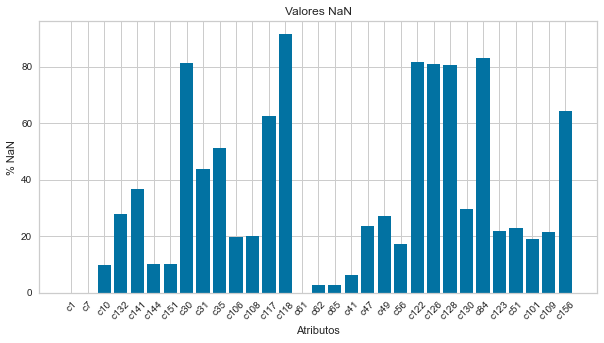

In [15]:
def plot_nan(df):
    """
    Imprimir el porcentaje de valores faltantes
    """
    def df_info_perc(df) -> dict:
        """
        Obtener el porcentaje de datos faltantes para plotear
        """
        # Diccionario con datos
        info_dic = {}
        # Numero de datos faltantes para las diferentes columnas
        rows = len(df)
        # print('\tCOLUMN\tNAN\tPERC')
        for col in df:        
            nan_values = df[col].isna().sum()
            perc = round((nan_values/rows) * 100, 2)
            # print(f'[+]\t{col}\t{nan_values}\t{perc}%')

            # Almacenar datos descriptivos
            info_dic.update({col: perc})

        return info_dic
    # Describir los datos faltantes
    info = df_info_perc(df)

    # Mostrar informacion
    plt.figure(figsize=(10, 5))
    plt.bar(info.keys(), info.values())
    plt.xlabel('Atributos')
    plt.xticks(rotation=45)
    plt.ylabel('% NaN')
    plt.title('Valores NaN')

    plt.show()
    
plot_nan(df)

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Porcentaje de valores NaN.</i></div>

El modelo que se desea realizar, debe de ser capaz de predecir el tipo de incidente que ocurrirá. Para ver si tenemos unos datos balanceados, a continuación se muestra una gráfica de la predicción a realizar, en donde podemos observa que si existe un balance de datos.

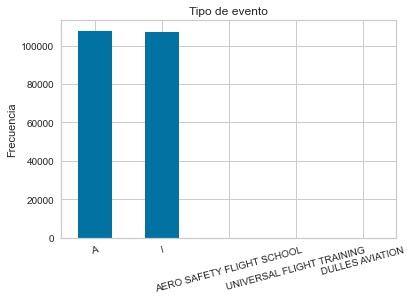

In [16]:
ax = df.c1.value_counts().plot(kind='bar', title='Tipo de evento')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Balanceo de clases.</i></div>

<p>A continuación se muestra el balanceo de datos para la columna del mes del incidente. Teniendo en cuenta el tipo de análisis a realizar, se realiza una previa visualización de la distribución de los sucesos por esta catacteristica.</p>

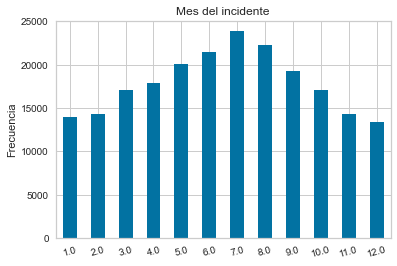

In [17]:
# Obtener la serie de conteos y ordenar los índices alfabéticamente
serie_counts = df.c7.value_counts().sort_index()

# Reordenar los valores de la serie según el nuevo orden de los índices
serie_counts = serie_counts.reindex(serie_counts.index.sort_values())

# Generar el gráfico de barras
ax = serie_counts.plot(kind='bar', title='Mes del incidente')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Frecuencia de sucesos por mes.</i></div>

<h4><div style="font-size:14px; text-align:center"><b>DESCRIPCIÓN DE VALORES</b><br></div></h4>

Dado el elevado numero de datos faltantes y sabiendo que existe valores que están en columnas diferentes por el estudio realizado para obtener el dataset de trabajo. A continuación se detalla los valores que existe para cada uno de los atributos del modelo de datos obtenido.

In [18]:
# Iterar las columnas y mostrar los valores únicos
for col in df:
    print(f"[+] {col}\t{col_name(col)}")
    print(f"VALUES\t{df[col].unique()}\n")

[+] c1	Type of Event
VALUES	['A' 'I' nan 'AERO SAFETY FLIGHT SCHOOL' 'UNIVERSAL FLIGHT TRAINING'
 'DULLES AVIATION']

[+] c7	Month the accident/incident happened.
VALUES	[ 1.  2.  3.  4.  5.  6.  7. 10.  9.  8. 11. 12. nan]

[+] c10	Local time of the accident/incident.
VALUES	[nan '0000' '1515' ... '4105' '0129' '0239']

[+] c132	First remedial action area code
VALUES	[nan 'A' 'Z' 'B' 'F' 'Y' 'E' 'W' 'I' 'P' 'K' 'M' 'G' 'V' 'O' 'J' 'T' 'N'
 'Q' 'H' 'R' 'L' 'C' 'S' 'X' 'U' 'D']

[+] c141	Method of notification
VALUES	[nan 'ATS' 'OPP' 'OTH' 'DOD' 'FAA' 'USG' 'LSG' 'AFS' 'NTS']

[+] c144	Code for Aircraft Design
VALUES	['1L71' '1H71' '2L72' '2L74' nan '1L72' '1G71' '1H72' '1K00' '1Q71' '2M74'
 '2H72' '2G71' '1B00' '2M72' '2L73' '2G72' '1K71' '1M71' '1G72' '2H71'
 '1L74' '2H73' '1H73' '2H74' '2Q73' '1B72' '1D71' '1M72' '2L71' '2D74'
 '1G00' '1H74' '1B71' '1K72' '1H81' '2X74' '2M71' '2S72' '1L00' '2D71'
 '1H00' '2Q72' '1K0' '1B0' '1S71' '1W71' '1X72' '1F71' '1K7' '1L73' '1X71'
 '1P71' '1E71

<h4><div style="font-size:14px; text-align:center"><b>CONCLUSIÓN</b><br></div></h4>

<p>Como se puede observar, existe la mitad de columnas que contiene más del 50% de datos nulos o vacíos que habrá que tener en cuenta a la hora de la selección de caracteristicas para nuestro estudio. Además de valores atípicos para su columna por encontrarse desplazados.</p>
<p>Se observa que las clases de estudio (Accidente o Incidente) están balanceadas</p>
<p>Por último, analizando el tipo de datos para el dataframe, se observa que la gran mayoría de atributos hace referencia a tipo objeto. Se debe a que determinados de estos atributos, tiene datos categóricos que mezcla numeros y letras en sus datos. No obstante, se analiza más adelante cuál de estas son realmente este tipo de columnas y cuáles son fruto de un error en los datos.</p>


## DATA PREPROCESSING (DP)

Con las conclusiones extraídas en el apartado anterior, en este apartado se realiza las correccciones necesarias para corregir estos errores.

<h3><div style="font-size:14px; text-align:center"><b>ELIMINAR CARACTERÍSTICAS</b></div></h3>

Las columna c118  tiene demasiados valores nulos, por lo que una imputación de valores podría afectar negativamente a la predicción

In [19]:
# Eliminar columnas indeseadas o con alto porcentaje de valores nulos
df = df.drop(columns=['c118'])

<h3><div style="font-size:14px; text-align:center"><b>VALORES DESPLAZADOS  Y VALORES ATIPICOS</b></div></h3>

A continuación, se define los valores que ha de tener cada una de las columnas categóricas para encontrar en que otras columnas puede existir y asi poder relocalizarlas. Esta busqueda se realiza sobre todo el dataset, de este modo, se podrá importar esos valores a las columnas del dataset de estudio.

<h4><div style="font-size:14px; text-align:left"><b>ANALISIS</b></div></h4>

Vamos a contar los valores de las columnas que a priori parecen categoricas para poder identificar algunos valores que no deberían estar en determinadas columnas debido a un desplazamiento, generando un valor atipico

In [20]:
# Lista de columnas categoricas a recorrer 
columnas = ["c1","c7","c144",
            "c106","c108","c51",
            "c101","c109",
            "c132","c141","c151","c35",
            "c117","c47",
            "c122","c126","c128","c130",
            "c84","c123","c156","c49","c41","c30"]  # Agrega aquí todas las columnas que deseas recorrer

for columna in columnas:
    # Obtener los valores repetidos y contar su frecuencia
    repeated_values = df[columna].value_counts()
    
    # Crear un DataFrame con los valores repetidos y su frecuencia
    repeated_values_df = repeated_values.to_frame()
    repeated_values_df.columns = ['Frequency']
    
    # Ordenar por las categorías menos frecuentes
    repeated_values_df = repeated_values_df.sort_values(by='Frequency')
    
    # Imprimir el nombre de la columna
    print("Columna:", columna)
    
    # Imprimir el DataFrame
    print(repeated_values_df)
    print()  # Agregar una línea en blanco después de cada columna

Columna: c1
                           Frequency
AERO SAFETY FLIGHT SCHOOL          1
UNIVERSAL FLIGHT TRAINING          1
DULLES AVIATION                    1
I                             106855
A                             107777

Columna: c7
      Frequency
12.0      13386
1.0       13927
11.0      14257
2.0       14273
3.0       17029
10.0      17081
4.0       17844
9.0       19267
5.0       20094
6.0       21400
8.0       22203
7.0       23871

Columna: c144
      Frequency
GR            1
1X72          1
1K7           1
1L73          1
2Q72          1
...         ...
1G71       9948
2L72      13756
1L72      22496
1L71      50589
1H71      72427

[63 rows x 1 columns]

Columna: c106
            Frequency
19550927.0          1
19620714.0          1
19760912.0          1
19700202.0          1
19680726.0          1
19691204.0          1
19641127.0          1
19560306.0          1
19691006.0          1
19961002.0          1
19670626.0          1
19930126.0          1
19571026.0    

#### c1,c106, c108, c123

Como puede observarse c1, c106, c108 y c123 presenta valores que son poco comunes ya que solo se repiten una vez y esos valores no concuerdan con el resto por lo que procedemos la eliminación de la fila eliminación <br>

#### c144,c35,c122,c126,c128

Estas columnas requieren de observación más detallada ya que su lista de valores es de mayor tamaño 

In [21]:
# Lista de columnas a recorrer
columnas = ["c144","c35","c122","c126","c128"]  # Agrega aquí todas las columnas que deseas recorrer

for columna in columnas:
    # Obtener los valores repetidos y contar su frecuencia
    repeated_values = df[columna].value_counts()
    
    # Crear un DataFrame con los valores repetidos y su frecuencia
    repeated_values_df = repeated_values.to_frame()
    repeated_values_df.columns = ['Frequency']
    
    # Ordenar por las categorías menos frecuentes
    repeated_values_df = repeated_values_df.sort_values(by='Frequency').head(50)
    
    # Imprimir el nombre de la columna
    print("Columna:", columna)
    
    # Imprimir el DataFrame
    print(repeated_values_df)
    print()  # Agregar una línea en blanco después de cada columna

Columna: c144
      Frequency
GR            1
1X72          1
1K7           1
1L73          1
2Q72          1
2D71          1
1E71          1
TD            1
1L00          1
2S72          1
OT            1
2X74          1
1H81          1
2Q73          1
1K01          1
1H74          2
LR            2
LA            3
1K72          3
MN            3
TC            4
1S71          4
CR            4
1H00          5
LT            5
1X71          5
2M71          8
1F71          8
2H73          9
1K0           9
2D74         10
1G00         10
1B71         12
1P71         15
2M74         15
1H73         17
2H71         19
1B0          22
1L74         23
1W71         31
1B72         31
1D71         43
2L71         63
2G71         89
2G72        119
1K71        219
2H74        232
2M72        249
1M72        595
1G72        858

Columna: c35
               Frequency
C20R/2                 1
R-755-B2               1
IO-375-B1B             1
INNTEC 800             1
CONT- O-300A           1
3-300A

Tras ver los resultados,se puede apreciar que estas columnas no presenta ninguna alteración.

<h4><div style="font-size:14px; text-align:left"><b>ACCIONES</b></div></h4>

Tras poderse comprobar que  c1,c106 y c108 presentan valores atipicos se proceden a borrar las filas que alteran la variable  ya que son pocos registros los afectados y no alteraría la predicción.La columna c123 le ocurre algo similar presenta pocos valores de P en relación con el resto por lo que se tratará como un valor no valido para esta columna

In [22]:
#c1
df = df.drop(df[df['c1'] == 'AERO SAFETY FLIGHT SCHOOL'].index)
df = df.drop(df[df['c1'] == 'UNIVERSAL FLIGHT TRAINING'].index)
df = df.drop(df[df['c1'] == 'DULLES AVIATION'].index)

#c106
df = df.drop(df[df['c106'] == '19550927.0'].index)
df = df.drop(df[df['c106'] == '19620714.0'].index)
df = df.drop(df[df['c106'] == '19760912.0'].index)
df = df.drop(df[df['c106'] == '19700202.0'].index)
df = df.drop(df[df['c106'] == '19680726.0'].index)
df = df.drop(df[df['c106'] == '19691204.0'].index)
df = df.drop(df[df['c106'] == '19641127.0'].index)
df = df.drop(df[df['c106'] == '19560306.0'].index)
df = df.drop(df[df['c106'] == '19691006.0'].index)
df = df.drop(df[df['c106'] == '19961002.0'].index)
df = df.drop(df[df['c106'] == '19670626.0'].index)
df = df.drop(df[df['c106'] == '19930126.0'].index)
df = df.drop(df[df['c106'] == '19571026.0'].index)
df = df.drop(df[df['c106'] == '19440916.0'].index)
df = df.drop(df[df['c106'] == '19540228.0'].index)

#c108
df = df.drop(df[df['c108'] == '19890602.0'].index)

#c123
df = df.drop(df[df['c123'] == 'P'].index)



### varibles numéricas

In [23]:
# Lista de columnas a recorrer
columnas = ["c61","c62","c65","c10","c31","c56"] 

for columna in columnas:
    # Obtener los valores repetidos y contar su frecuencia
    repeated_values = df[columna].value_counts()
    
    # Crear un DataFrame con los valores repetidos y su frecuencia
    repeated_values_df = repeated_values.to_frame()
    repeated_values_df.columns = ['Frequency']
    
    # Ordenar por las categorías menos frecuentes
    repeated_values_df = repeated_values_df.sort_values(by='Frequency').head(50)
    
    # Imprimir el nombre de la columna
    print("Columna:", columna)
    
    # Imprimir el DataFrame
    print(repeated_values_df)
    print()  # Agregar una línea en blanco después de cada columna

Columna: c61
       Frequency
394.0          1
476.0          1
459.0          1
375.0          1
403.0          1
423.0          1
453.0          1
321.0          1
356.0          1
348.0          1
320.0          1
488.0          1
450.0          1
501.0          1
493.0          1
466.0          1
350.0          1
467.0          1
409.0          1
378.0          1
289.0          1
355.0          1
351.0          1
363.0          1
306.0          1
420.0          1
401.0          1
319.0          1
510.0          1
429.0          1
333.0          1
359.0          1
477.0          1
411.0          1
421.0          1
498.0          1
435.0          1
391.0          1
345.0          1
314.0          1
330.0          1
447.0          1
434.0          1
316.0          1
329.0          1
600.0          1
278.0          1
432.0          1
497.0          1
368.0          1

Columna: c62
       Frequency
307.0          1
377.0          1
504.0          1
315.0          1
388.0          1
361.

Trás dicha comprobación no aparenta tener datos atipicos o registros desplazados

<h3><div style="font-size:14px; text-align:center"><b>FORMATEADO DE DATOS</b></div></h3>

Ya tenemos comprobado el desplazamiento y valores atipicos, por lo que el siguiente paso sería la verificación y adecuación de los datos para que pueda ser interpretado correctamente por el algoritmo de predicción.<br>

***NOTA***<br>
*Los datos aquí indicados como categóricos o numéricos, no son necesariamente de dicha índole para el estudio del modelo, esta agrupación se ha realizado por tipo de datos contenido pero no por significado para el modelo final.*

In [24]:
# Identificar los valores que no son de la columna y convertirlos a NaN
def validate_values(col: pd.Series, cat_values: list):
    def clean_data(value):
        if value in cat_values:
            cat_type = type(cat_values[0])
            if not isinstance(value, cat_type):
                if cat_type == str:
                    return str(value)
                elif cat_type == int:
                    return int(value)
                elif cat_type == float:
                    return float(value)
                
            return value
        else:
            return np.nan
    return col.apply(clean_data)  

In [25]:
def foreign_values(c_origin, searched_values, c_foreign, dataframe: pd.DataFrame, source_df: pd.DataFrame = data_df):
    moved = 0
    match = 0
    origin_values = []

    for index, values in source_df.iterrows():
        if values[c_foreign] in searched_values:
            match += 1
            # Si el valor de la columna en origen es NaN, traer el valor de la columna erronea
            # si su valor pertenece a la columna.
            if pd.isna(values[c_origin]):
                dataframe.loc[index, c_origin] = values[c_foreign]
                moved += 1
            else:
                origin_values.append(values[c_foreign])

    print(f'\tMATCH\t{match}\tMOVED\t{moved}')
    if origin_values:
        print(f'\t[!] VALUES_IN_ORIGIN\t{origin_values}')

<h6><div style="font-size:14px; text-align:left"><b>c10 Local time of the accident/incident</b><br></div></h6>

In [26]:
col = 'c10'

# Observar los valores de la columna
print(f"[+] {col}\t{col_name(col)}")
print(f"VALUES\t{df[col].unique()}\n")

[+] c10	Local time of the accident/incident.
VALUES	[nan '0000' '1515' ... '4105' '0129' '0239']



La columna c10 contiene los datos de la hora del incidente, pero para poder lidiar con todos los datos, se convierte los valores dados en formato HHMM en HH. Para ello, se recorre todos los valores y se modifica su valor, además, si los minutos son más de 30, se sumará una hora al resultado.<br>
Se toma esta decisión para no sobrepasar al modelo de características para este atributo.

In [27]:
def get_hour(value):
    """
    Convertir la hora en HHMM a HH
    """
    try:
        if value in[None, 'nan']:
            return np.NaN
        
        # Extraer la hora y minuto
        hour = int(value[:2])
        # Comprobar que la hora sea correcta y no sea un valor
        # ilogico
        if hour >= 24:
            return np.NaN
        minute = int(value[2:])
        hour += 1 if minute > 30 else 0
        # Cambiar la hora a 00 para aquellas que sumen 1 y sea las 23
        hour = 0 if hour == 24 else hour
        
        return str(hour).zfill(2)
    
    except (TypeError, Exception):
        return np.NaN
    
# Utilizar compresion de listas y aplicar el filtrado de valores
hours = [get_hour(value) for value in df['c10']]
df['c10'] = hours

df.c10.unique()

array([nan, '00', '15', '14', '09', '13', '11', '20', '22', '18', '16',
       '19', '21', '10', '08', '12', '17', '07', '01', '06', '23', '05',
       '02', '04', '03'], dtype=object)

<h6><div style="font-size:14px; text-align:left"><b>Conversión de columnas mal identificadas como string a numericas</b><br></div></h6>

In [28]:
# Iterar las columnas y mostrar los valores únicos y ver si son númericas o string
for col in df:
    print(f"[+] {col}\t{col_name(col)}")
    print(f"VALUES\t{df[col].unique()}\n")

[+] c1	Type of Event
VALUES	['A' 'I' nan]

[+] c7	Month the accident/incident happened.
VALUES	[ 1.  2.  3.  4.  5.  6.  7. 10.  9.  8. 11. 12. nan]

[+] c10	Local time of the accident/incident.
VALUES	[nan '00' '15' '14' '09' '13' '11' '20' '22' '18' '16' '19' '21' '10' '08'
 '12' '17' '07' '01' '06' '23' '05' '02' '04' '03']

[+] c132	First remedial action area code
VALUES	[nan 'A' 'Z' 'B' 'F' 'Y' 'E' 'W' 'I' 'P' 'K' 'M' 'G' 'V' 'O' 'J' 'T' 'N'
 'Q' 'H' 'R' 'L' 'C' 'S' 'X' 'U' 'D']

[+] c141	Method of notification
VALUES	[nan 'ATS' 'OPP' 'OTH' 'DOD' 'FAA' 'USG' 'LSG' 'AFS' 'NTS']

[+] c144	Code for Aircraft Design
VALUES	['1L71' '1H71' '2L72' '2L74' nan '1L72' '1G71' '1H72' '1K00' '1Q71' '2M74'
 '2H72' '2G71' '1B00' '2M72' '2L73' '2G72' '1K71' '1M71' '1G72' '2H71'
 '1L74' '2H73' '1H73' '2H74' '2Q73' '1B72' '1D71' '1M72' '2L71' '2D74'
 '1G00' '1H74' '1B71' '1K72' '1H81' '2X74' '2M71' '2S72' '1L00' '2D71'
 '1H00' '2Q72' '1K0' '1B0' '1S71' '1W71' '1X72' '1F71' '1K7' '1L73' '1X71'
 '1P71

In [29]:
df['c61'] = pd.to_numeric(df['c61'], errors='coerce').astype('float32')
df['c62'] = pd.to_numeric(df['c62'], errors='coerce').astype('float32')
df['c65'] = pd.to_numeric(df['c65'], errors='coerce').astype('float32')
df['c31'] = pd.to_numeric(df['c31'], errors='coerce').astype('float32')
df['c56'] = pd.to_numeric(df['c56'], errors='coerce').astype('float32')
df['c10'] = pd.to_numeric(df['c10'], errors='coerce').astype('float32')
#df['c145'] = pd.to_numeric(df['c145'], errors='coerce').astype('float32')
df['c151'] = pd.to_numeric(df['c151'], errors='coerce').astype('float32')
df['c7'] = pd.to_numeric(df['c7'], errors='coerce').astype('float32')


In [30]:
df.dtypes

c1       object
c7      float32
c10     float32
c132     object
c141     object
c144     object
c151    float32
c30      object
c31     float32
c35      object
c106     object
c108     object
c117     object
c61     float32
c62     float32
c65     float32
c41      object
c47     float64
c49      object
c56     float32
c122     object
c126     object
c128     object
c130     object
c84      object
c123     object
c51      object
c101     object
c109     object
c156     object
dtype: object

<h3><div style="font-size:14px; text-align:center"><b>División en columnas categoricas string, categoricas numéricas y numericas</b><br></div></h3>

In [31]:
# Podemos apreciar la cantidad de valores unicos de cada columna
# vamos a establecer que los que tengan más de 100 valores unicos son numericos y los restantes categoricos

for col in df.columns:
    print(col, df[col].nunique())

c1 2
c7 12
c10 24
c132 26
c141 9
c144 61
c151 5
c30 6
c31 18380
c35 3961
c106 3
c108 23
c117 9
c61 431
c62 412
c65 13
c41 19
c47 10
c49 14
c56 13158
c122 7124
c126 11167
c128 285
c130 10
c84 26
c123 3
c51 16
c101 17
c109 5
c156 11


In [32]:
# Separar variables tipo float y almacenar variables categóricas en una lista
str_cols = []
num_cols = []


columnas = ["c1","c7","c144",
            "c106","c108","c51",
            "c101","c109",
            "c132","c141","c151","c35",
            "c117","c47",
            "c122","c126","c128","c130",
            "c84","c123","c156","c49","c41",
            "c30","c61","c62","c65","c10","c31","c56"] 

for columna in columnas:
    if df[columna].dtype == 'object':
        str_cols.append(columna)
    else:
        num_cols.append(columna)

print("Columnas tipo string:", str_cols)
print("Columnas  tipo numérica:", num_cols)


Columnas tipo string: ['c1', 'c144', 'c106', 'c108', 'c51', 'c101', 'c109', 'c132', 'c141', 'c35', 'c117', 'c122', 'c126', 'c128', 'c130', 'c84', 'c123', 'c156', 'c49', 'c41', 'c30']
Columnas  tipo numérica: ['c7', 'c151', 'c47', 'c61', 'c62', 'c65', 'c10', 'c31', 'c56']


In [33]:
#Vamos a establecer como criterio de clasificación las que superen 100 caracteres unicos serán numericas
#las restantes serán categoricas

# Definimos una lista para almacenar las columnas numéricas
num_cols_cat = []

# Definimos una lista para almacenar las columnas categóricas
num_cols_ncat = []

# Verificamos la cardinalidad de cada columna
for col in num_cols:
    unique_vals = df[col].nunique()
    if unique_vals >= 100:
        num_cols_ncat.append(col)
    else:
        num_cols_cat.append(col)

# Imprimimos las columnas numéricas y categóricas
print("Columnas numericas no categoricas:", num_cols_ncat)
print("Columnas categoricas numericas:", num_cols_cat)
print("Columnas categoricas string:", str_cols)

Columnas numericas no categoricas: ['c61', 'c62', 'c31', 'c56']
Columnas categoricas numericas: ['c7', 'c151', 'c47', 'c65', 'c10']
Columnas categoricas string: ['c1', 'c144', 'c106', 'c108', 'c51', 'c101', 'c109', 'c132', 'c141', 'c35', 'c117', 'c122', 'c126', 'c128', 'c130', 'c84', 'c123', 'c156', 'c49', 'c41', 'c30']


In [34]:
#La columna c65 debe ser numerica no categorica ,debido a su naturaleza, es decir, hace referencia a la cantidad de tripulantes.
num_cols_ncat= ['c61', 'c62', 'c31', 'c56','c65']
num_cols_cat= ['c7', 'c151', 'c47', 'c10']
str_cols=['c1', 'c144', 'c106', 'c108', 'c51', 'c101', 'c109', 'c132', 'c141', 'c35', 'c117', 'c122', 'c126', 'c128', 'c130', 'c84', 'c123', 'c156', 'c49', 'c41', 'c30']

<h3><div style="font-size:14px; text-align:center"><b>IMPUTACION DE VALORES de COLUMNAS NUMERICAS CATEGORICASs</b><br></div></h3>

In [35]:
print(df.isna().sum())

c1          16
c7          16
c10      25651
c132     59593
c141     78607
c144     22107
c151     22147
c30     174613
c31      94292
c35     110168
c106     42708
c108     42953
c117    134082
c61         16
c62       5946
c65       5946
c41      13760
c47      50957
c49      58505
c56      37032
c122    175295
c126    173558
c128    173038
c130     63897
c84     178115
c123     47080
c51      49645
c101     41170
c109     46179
c156    137889
dtype: int64


In [36]:
# Imputación para columnas numéricas categoricas
#num_cols = data.select_dtypes(include=['float', 'int']).columns.tolist()
num_imputer = KNNImputer(n_neighbors=5)
df[num_cols_cat] = num_imputer.fit_transform(df[num_cols_cat])

In [37]:
print(df.isna().sum())

c1          16
c7           0
c10          0
c132     59593
c141     78607
c144     22107
c151         0
c30     174613
c31      94292
c35     110168
c106     42708
c108     42953
c117    134082
c61         16
c62       5946
c65       5946
c41      13760
c47          0
c49      58505
c56      37032
c122    175295
c126    173558
c128    173038
c130     63897
c84     178115
c123     47080
c51      49645
c101     41170
c109     46179
c156    137889
dtype: int64


In [38]:
df.to_csv('imputado_num_cols_cat.csv', index=False)

<h3><div style="font-size:14px; text-align:center"><b>IMPUTACION DE VALORES de COLUMNAS NUMERICAS NO CATEGORICASs</b><br></div></h3>

In [39]:
#df = pd.read_csv('imputado_num_cols_cat.csv')

In [40]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Imputación para columnas numéricas no categóricas
num_imputer = IterativeImputer()

# Imputar las columnas numéricas no categóricas
df[num_cols_ncat] = num_imputer.fit_transform(df[num_cols_ncat])

In [41]:
print(df.isna().sum())

c1          16
c7           0
c10          0
c132     59593
c141     78607
c144     22107
c151         0
c30     174613
c31          0
c35     110168
c106     42708
c108     42953
c117    134082
c61          0
c62          0
c65          0
c41      13760
c47          0
c49      58505
c56          0
c122    175295
c126    173558
c128    173038
c130     63897
c84     178115
c123     47080
c51      49645
c101     41170
c109     46179
c156    137889
dtype: int64


In [42]:
df.to_csv('imputado_num_cols_ncat.csv', index=False)

In [43]:
#df = pd.read_csv('imputado_num_cols_ncat.csv')

<h3><div style="font-size:14px; text-align:center"><b>IMPUTACION DE VALORES de COLUMNAS STRING</b><br></div></h3>

In [44]:
print(df.isna().sum())

c1          16
c7           0
c10          0
c132     59593
c141     78607
c144     22107
c151         0
c30     174613
c31          0
c35     110168
c106     42708
c108     42953
c117    134082
c61          0
c62          0
c65          0
c41      13760
c47          0
c49      58505
c56          0
c122    175295
c126    173558
c128    173038
c130     63897
c84     178115
c123     47080
c51      49645
c101     41170
c109     46179
c156    137889
dtype: int64


In [45]:
df_raw = df

# 1st possibility
label_encoder = LabelEncoder()  # Crear una instancia del codificador

# Ajustar el codificador a los datos
df_temp = df_raw.astype("str").apply(label_encoder.fit_transform)
df_final = df_temp.where(~df_raw.isna(), df_raw)


In [46]:
# Imputación de valores faltantes para las columnas categóricas mediante KNNImputer
imputer = KNNImputer(n_neighbors=1)
df_final[str_cols] = imputer.fit_transform(df_final[str_cols])

In [47]:
print(df_final.isna().sum())

c1      0
c7      0
c10     0
c132    0
c141    0
c144    0
c151    0
c30     0
c31     0
c35     0
c106    0
c108    0
c117    0
c61     0
c62     0
c65     0
c41     0
c47     0
c49     0
c56     0
c122    0
c126    0
c128    0
c130    0
c84     0
c123    0
c51     0
c101    0
c109    0
c156    0
dtype: int64


In [48]:
# Realizar la decodificación manualmente
df_decoded = df_final.copy()
for column in df_decoded.columns:
    mapping = {label: original for label, original in zip(df_temp[column].unique(), df_raw[column].unique())}
    df_decoded[column] = df_decoded[column].map(mapping)

In [49]:
print(df_decoded.isnull().sum())

c1      8
c7      0
c10     0
c132    8
c141    8
c144    8
c151    0
c30     8
c31     0
c35     8
c106    8
c108    8
c117    8
c61     0
c62     0
c65     0
c41     8
c47     0
c49     8
c56     0
c122    8
c126    8
c128    8
c130    8
c84     8
c123    8
c51     8
c101    8
c109    8
c156    8
dtype: int64


In [50]:
# Find rows with null values
null_rows = df_decoded[df_decoded.isnull().any(axis=1)]

# Print rows with null values
print(null_rows)

         c1      c7       c10 c132 c141 c144      c151  c30          c31  c35  \
191765  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   
197521  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   
198790  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   
201670  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   
210980  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   
210981  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   
213131  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   
213132  NaN  6.5239  14.01262  NaN  NaN  NaN  1.286345  NaN  5010.591309  NaN   

        ... c122 c126 c128  c130  c84  c123  c51  c101 c109  c156  
191765  ...  NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN  
197521  ...  NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN  
198790  ...  NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN 

In [51]:
df.shape

(214635, 30)

In [52]:
df_decoded.shape

(214635, 30)

In [53]:
df = df_decoded.dropna()


In [54]:
df_decoded.shape


(214635, 30)

In [55]:
# Find rows with null values
null_rows = df[df.isnull().any(axis=1)]

In [56]:
# Print rows with null values
print(null_rows)

Empty DataFrame
Columns: [c1, c7, c10, c132, c141, c144, c151, c30, c31, c35, c106, c108, c117, c61, c62, c65, c41, c47, c49, c56, c122, c126, c128, c130, c84, c123, c51, c101, c109, c156]
Index: []

[0 rows x 30 columns]


In [57]:
df.to_csv('imputado_completo.csv', index=False)

In [58]:
#df = pd.read_csv('imputado_completo.csv')

## FEATURE ENGINEERING (FE)

A continuación, se realiza una serie de modificaciones en los datos para que estos puedan ser interpretados por el modelo.

<h3><div style="font-size:14px; text-align:center"><b>CODIFICACIÓN DE DATOS CATEGÓRICOS</b></div></h3>

Existe una serie de columnas con datos categóricos que se deberá de codificar para poder tratar sus datos y realizar nuestra prediccion del modelo.<br>
Hasta ahora se ha trabajado con las columnas categóricas y numéricas em base a sus datos, pero, para realizar la codificación necesaria, se va a realizar sobre todas las columnas que necesariamente serán categóricas para realizar el modelo.<br>
Existe tres técnicas de Data Encoding dependiendo de las carácteristicas de los atributos:<br>
- OrdinalEncoder: Se utiliza para codificar variables categóricas que no tienen una relación de orden natural. Devuelve una unica columna que va de 1 a n_caracteristicas-1.
- LabelEncoder: Se utiliza para codificar variables categóricas que tienen una relación de orden natural. Devuelve una columna de 1 a n_caracteristicas-1. Su uso se realiza principalmente para transformar la variable dependiente.
- OneHotEncoder: Se utiliza para codificar variables categóricas que no tienen una relación de orden natural. Devuelve una columna para cada atributo codificado, indicando 0 o 1 según la presencia de la carateristica para cada registro.
<br>

A continuación se muestra los tipos de datos categoricos del dataset para seleccionar que tecnica emplear con cada atributo.

In [59]:
df['c65'] = df['c65'].astype(int)
df['c151'] = df['c151'].astype(int)

In [60]:
num_cols_ncat= ['c61', 'c62', 'c31', 'c56', 'c65']
num_cols_cat= ['c7', 'c151', 'c47', 'c10']
str_cols= ['c1', 'c144', 'c106', 'c108', 'c51', 'c101', 'c109', 'c132', 'c141', 'c35', 'c117', 'c122', 'c126', 'c128', 'c130', 'c84', 'c123', 'c156', 'c49', 'c41', 'c30']


In [61]:
# LabelEncoder
col_le = ["c1"]
# OrdinalEncoder
col_oe = ['c144', 'c106', 'c108', 'c51', 'c101', 'c109', 'c132', 'c141', 'c35', 'c117', 'c122', 'c126', 'c128', 'c130', 'c84', 'c123', 'c156', 'c49', 'c41', 'c30']

# Cambio de tipo
col_retype = ['c7', 'c151', 'c47', 'c10']

col_oe.extend(col_retype)

Para aquellos atributos que sus datos categoricos, son todos numéricos, simplemente se les aplica un cambio de tipo de datos a entero para poder ser interpretado por el modelo, **col_retype**.
Para la variable dependiente u objetivo, c1, así como para los atributos de entrada cuyos datos tienen un orden de relación, se emplea LabelEncoder, **col_le**.
Para los atributos cuyas clases no están relacionadas, se emplea OrdinalEncoder. Para el resto de columnas se ha realizado un OrdinalEncoder, **col_oe**.

<h4><div style="font-size:14px; text-align:left"><b>LabelEncoder</b></div></h4>

Para la transformación de los datos, se guarda el diccionario de los datos que se va a mapear para poder emplearlo en la entrada de nuevos datos.

In [62]:
# Instancia del codificador
le = LabelEncoder()

mapped_dic = {}
for col in col_le:
    # Ajuste de los datos y transformación
    df[col] = le.fit_transform(df[col])
    # Añadir valores al diccionario
    mapped_dic.update({col: dict(zip(le.transform(le.classes_), le.classes_))})
    
mapped_le = pd.DataFrame.from_dict(mapped_dic, orient='index').fillna('-')
mapped_le

,0,1
c1,A,I


In [63]:
df

,c1,c7,c10,c132,c141,c144,c151,c30,c31,c35,...,c122,c126,c128,c130,c84,c123,c51,c101,c109,c156
0,0,1.0,13.0,B,OPP,1L71,1,STRD,1000.598999,IO360A1B6,...,VXFG,VXFG075W,GL15,None,U,U,PROFESSIONAL PILOT,Personal,Dusk,RECIPROCATING-OPPOSED
1,0,1.0,13.0,Z,OTH,1H71,1,STRD,656.053772,O320A2B,...,HSYA,HSYA817E,NM05,None,T,Y,STUDENT,Personal,Day,RECIPROCATING-OPPOSED
2,0,1.0,14.0,B,OTH,1H71,1,STRD,604.672729,IO320*,...,KBNA,KBNA479F,SW03,Instrument Flight Ru,K,N,OTHER,Other,Dawn,RECIPROCATING-OPPOSED
3,0,1.0,14.0,Z,OPP,1H71,1,STRD,647.717896,4AC199E3,...,W94L,W94L094I,NM01,None,U,U,ENGINEER,Personal,Day,RECIPROCATING-OPPOSED
4,0,1.0,14.0,Z,OTH,1H71,1,STRD,770.904541,O320B2B,...,HSYA,HSYA817E,NM05,None,F,Y,OTHER,Business,Day,RECIPROCATING-OPPOSED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214659,1,2.0,17.0,B,ATS,1H71,1,STRD,929.000000,O-200A,...,AAL,SWLIT140T,SO63,Instrument Flight Ru,K,U,UNKNOWN,Business,Day,RECIPROCATING-INLINE
214660,1,2.0,15.0,Z,ATS,1L71,1,STRD,1823.000000,TSIO-550 SER,...,SWA,SWLIT140T,SO63,None,K,Y,UNKNOWN,Personal,Day,RECIPROCATING-OPPOSED
214661,1,1.0,9.0,B,ATS,1H71,1,STRD,970.000000,IO-360-B1G6,...,7UVS,AT70480,SO04,None,K,U,UNKNOWN,Business,Day,RECIPROCATING-OPPOSED
214662,1,1.0,4.0,Y,ATS,2H72,1,STRD,11767.455078,TPE331-12UHR,...,VPOA,SWSAT91T,SW64,Instrument Flight Ru,J,U,PROFESSIONAL PILOT,Scheduled Air Carrie,Night,TURBOPROP


<h4><div style="font-size:14px; text-align:left"><b>OrdinalEncoder</b></div></h4>

In [64]:
# Instancia del codificador
oe = OrdinalEncoder()

cat_cols_mapped = []
for col in col_oe:
    df[col] = oe.fit_transform(df[[col]])
    categories = list(oe.categories_[0])
    
    # Añadir valores al diccionario
    mapped_dic.update({col: {idx: cat for idx, cat in enumerate(categories)}})
    
    # Añadir columnas a lista de columnas transformadas
    cat_cols_mapped.append(col)

mapped_df = pd.DataFrame.from_dict(mapped_dic, orient='index').fillna('-')
mapped_df

,0,1,2,3,4,5,6,7,8,9,...,11157,11158,11159,11160,11161,11162,11163,11164,11165,11166
c1,A,I,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
c144,1B0,1B00,1B71,1B72,1D71,1E71,1F71,1G00,1G71,1G72,...,-,-,-,-,-,-,-,-,-,-
c106,A,B,C,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
c108,A,B,C,D,E,F,G,H,I,J,...,-,-,-,-,-,-,-,-,-,-
c51,ACCOUNTANT,COMPANY EXECUTIVE,CONTRACTOR,ENGINEER,"FARMER, RANCHER, CAT",GOVERNMENT EMPLOYEE,HOUSEWIFE,LAWYER,MINISTER,OTHER,...,-,-,-,-,-,-,-,-,-,-
c101,A/T Com (Sched 5/Mor,Aerial Applicator,Air Taxi (Non-Schedu,Air Taxi (Sched-Not,Air Taxi Oper-Large,All Cargo Carriers,Business,Executive,For Hire,"Illegal Drug, Stolen",...,-,-,-,-,-,-,-,-,-,-
c109,Dawn,Day,Dusk,Night,Unknown,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
c132,A,B,C,D,E,F,G,H,I,J,...,-,-,-,-,-,-,-,-,-,-
c141,AFS,ATS,DOD,FAA,LSG,NTS,OPP,OTH,USG,-,...,-,-,-,-,-,-,-,-,-,-
c35,(L) O-360-A1H,0,0 470-R,0-0200-A,0-145A SERIES,0-145B SERIES,0-160,0-200,0-200 A,0-200 J SERI,...,-,-,-,-,-,-,-,-,-,-


In [65]:
df

,c1,c7,c10,c132,c141,c144,c151,c30,c31,c35,...,c122,c126,c128,c130,c84,c123,c51,c101,c109,c156
0,0,0.0,28.0,1.0,6.0,23.0,1.0,5.0,1000.598999,1691.0,...,6343.0,10163.0,86.0,4.0,20.0,1.0,11.0,13.0,2.0,3.0
1,0,0.0,28.0,25.0,7.0,11.0,1.0,5.0,656.053772,2404.0,...,3035.0,5522.0,126.0,4.0,19.0,2.0,13.0,13.0,1.0,3.0
2,0,0.0,33.0,1.0,7.0,11.0,1.0,5.0,604.672729,1664.0,...,3649.0,5941.0,206.0,2.0,10.0,0.0,9.0,12.0,0.0,3.0
3,0,0.0,33.0,25.0,6.0,11.0,1.0,5.0,647.717896,325.0,...,6395.0,10201.0,122.0,4.0,20.0,1.0,3.0,13.0,1.0,3.0
4,0,0.0,33.0,25.0,7.0,11.0,1.0,5.0,770.904541,2413.0,...,3035.0,5522.0,126.0,4.0,5.0,2.0,9.0,6.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214659,1,1.0,49.0,1.0,1.0,11.0,1.0,5.0,929.000000,2187.0,...,605.0,9059.0,195.0,2.0,10.0,1.0,15.0,6.0,1.0,2.0
214660,1,1.0,39.0,25.0,1.0,23.0,1.0,5.0,1823.000000,3698.0,...,5773.0,9059.0,195.0,4.0,10.0,2.0,15.0,13.0,1.0,3.0
214661,1,0.0,10.0,1.0,1.0,11.0,1.0,5.0,970.000000,1519.0,...,452.0,3021.0,172.0,4.0,10.0,1.0,15.0,6.0,1.0,3.0
214662,1,0.0,4.0,24.0,1.0,40.0,1.0,5.0,11767.455078,3552.0,...,6311.0,9612.0,231.0,2.0,9.0,1.0,11.0,14.0,3.0,9.0


In [66]:
# Almacenar diccionario en .csv para su posterior uso
mapped_df.to_csv(f'{model_info_dir}mapped_dictionary.csv', index=True)
#Recuperar datos
#map_df = pd.read_csv('Forecast/mapped_dictionary.csv', index_col=0)
#value_mapped = map_df.loc['c114'].eq('2')
#value_mapped = value_mapped.idxmax() if value_mapped.any() else None
#try:
#    print(int(value_mapped))
#except:
#    print('Valor no encontrado')

<h4><div style="font-size:14px; text-align:left"><b>Mapeado de datos</b></div></h4>

In [67]:
# cambiar el tipo de datos a entero
#for col in col_retype:
#    df[col] = df[col].astype(int)
#    # Añadir columnas a lista de columnas transformadas
#    cat_cols_mapped.append(col)

<h3><div style="font-size:14px; text-align:center"><b>NORMALIZACIÓN ATRIBUTOS NUMÉRICOS</b></div></h3>

In [68]:
df[num_cols_ncat].describe()

,c61,c62,c31,c56,c65
count,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000
mean,6.253258,5.281607,5010.837891,3677.542236,0.731273
std,25.900677,24.827847,7778.141602,5090.016113,0.728859
min,0.000000,-6.439477,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1290.000000,406.000000,0.000000
50%,1.000000,0.000000,3266.858154,2000.000000,1.000000
75%,2.000000,1.000000,5134.085938,4500.000000,1.000000
max,824.000000,820.000000,157380.531250,92591.000000,42.000000


En base a la desviación estandar de determinadas columnas, que son elevadas, se realiza el normalizado de los datos y el escalado entre 0 y 1.

In [69]:
# Columnas a aplicar diferentes métodos
std_cols = ['c61', 'c62', 'c31', 'c56','c65']
#min_max_cols = ['c20', 'c240', 'c241']

# Instancia de los normalizados
std_scaler = StandardScaler(with_mean=False)
#min_max_scaler = MinMaxScaler()

# Ajuste de las instancias a los datos y guardado de estos
std_scaler.fit(df[std_cols])
#min_max_scaler.fit(df[min_max_cols])

joblib.dump(std_scaler, f'{model_info_dir}scaler_{"_".join(std_cols)}.joblib')
#joblib.dump(min_max_scaler, f'{model_info_dir}scaler_{"_".join(min_max_cols)}.joblib')
#scaler_new = joblib.load('scaler.joblib')
#df['c31'] = scaler_new.transform(df[['c31']])

# Transformación de los datos
df[std_cols] = std_scaler.transform(df[std_cols])
#df[min_max_cols] = min_max_scaler.transform(df[min_max_cols])

df.describe()

,c1,c7,c10,c132,c141,c144,c151,c30,c31,c35,...,c122,c126,c128,c130,c84,c123,c51,c101,c109,c156
count,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,...,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000,214627.000000
mean,0.497808,6.036724,33.577006,11.631426,4.822259,19.988082,1.256366,4.514069,0.644222,2119.364218,...,3840.454239,5670.584451,120.732755,4.102396,13.166195,1.144171,12.124029,10.650114,1.260731,3.761885
std,0.499996,3.605535,16.533989,11.996665,2.361439,10.952319,0.567152,1.437950,1.000002,906.846702,...,2030.029382,3017.571166,75.775765,1.744459,6.914254,0.704463,2.890776,3.953224,0.746414,1.922282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,18.000000,0.000000,3.000000,11.000000,1.000000,5.000000,0.165850,1686.000000,...,1637.000000,3377.000000,51.000000,3.000000,8.000000,1.000000,11.000000,11.000000,1.000000,3.000000
50%,0.000000,7.000000,33.000000,1.000000,6.000000,23.000000,1.000000,5.000000,0.420006,2355.000000,...,4354.000000,5941.000000,111.000000,4.000000,12.000000,1.000000,11.000000,13.000000,1.000000,3.000000
75%,1.000000,9.000000,49.000000,25.000000,7.000000,24.000000,1.000000,5.000000,0.660067,2527.000000,...,5680.000000,8247.000000,186.000000,4.000000,20.000000,2.000000,15.000000,13.000000,1.000000,3.000000
max,1.000000,12.000000,61.000000,25.000000,8.000000,60.000000,4.000000,5.000000,20.233741,3960.000000,...,7123.000000,11166.000000,284.000000,9.000000,25.000000,2.000000,15.000000,16.000000,4.000000,10.000000


<h3><div style="font-size:14px; text-align:center"><b>CONCLUSION</b></div></h3>

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214627 entries, 0 to 214663
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   c1      214627 non-null  int32  
 1   c7      214627 non-null  float64
 2   c10     214627 non-null  float64
 3   c132    214627 non-null  float64
 4   c141    214627 non-null  float64
 5   c144    214627 non-null  float64
 6   c151    214627 non-null  float64
 7   c30     214627 non-null  float64
 8   c31     214627 non-null  float64
 9   c35     214627 non-null  float64
 10  c106    214627 non-null  float64
 11  c108    214627 non-null  float64
 12  c117    214627 non-null  float64
 13  c61     214627 non-null  float64
 14  c62     214627 non-null  float64
 15  c65     214627 non-null  float64
 16  c41     214627 non-null  float64
 17  c47     214627 non-null  float64
 18  c49     214627 non-null  float64
 19  c56     214627 non-null  float64
 20  c122    214627 non-null  float64
 21  c126    21

## DATA MODELING

Crear el modelo de predicción con el conjunto de datos obtenido.

<h3><div style="font-size:14px; text-align:center"><b>DIVISION DE LOS DATOS</b></div></h3>

Para el modelado, se emplea unos datos de entrenamiento (train) y unos de prueba (test). Una vez el modelo está realizado, existe los datos de validación, estos no son vistos por el modelo durante el train o test.

A continuación, se parte los datos en:
- **data**: datos con los que se entrenará y testeará el modelo.
- **data_unseen**: datos que se emplearán para la validación (5% de los datos).

In [71]:
## sample devuelve una muestra aleatoria de un eje del objeto
data = df.sample(frac=0.75, random_state=786)
data

,c1,c7,c10,c132,c141,c144,c151,c30,c31,c35,...,c122,c126,c128,c130,c84,c123,c51,c101,c109,c156
72104,1,0.0,49.0,1.0,1.0,11.0,1.0,5.0,0.003214,2462.0,...,5680.0,8247.0,51.0,8.0,22.0,1.0,11.0,13.0,1.0,3.0
26705,1,3.0,56.0,0.0,4.0,11.0,1.0,5.0,0.085352,2552.0,...,5680.0,8247.0,51.0,4.0,20.0,1.0,15.0,13.0,3.0,3.0
106225,1,4.0,45.0,1.0,6.0,44.0,2.0,0.0,1.326349,3808.0,...,3427.0,5769.0,252.0,2.0,8.0,2.0,11.0,0.0,1.0,2.0
173204,0,9.0,33.0,1.0,7.0,8.0,1.0,5.0,0.058497,228.0,...,1555.0,6161.0,267.0,6.0,19.0,1.0,15.0,11.0,1.0,10.0
131016,1,9.0,10.0,0.0,1.0,44.0,2.0,5.0,1.170477,3532.0,...,5680.0,8247.0,51.0,2.0,25.0,1.0,11.0,7.0,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103482,0,12.0,28.0,25.0,7.0,11.0,1.0,5.0,0.327843,3765.0,...,1331.0,3590.0,124.0,4.0,14.0,2.0,9.0,11.0,1.0,3.0
213262,0,7.0,53.0,0.0,1.0,46.0,1.0,4.0,0.389811,2681.0,...,4530.0,1345.0,15.0,8.0,12.0,0.0,11.0,12.0,1.0,9.0
119880,1,9.0,56.0,25.0,1.0,44.0,2.0,0.0,1.712888,2775.0,...,1147.0,3463.0,212.0,2.0,20.0,2.0,11.0,0.0,1.0,9.0
70568,0,7.0,53.0,25.0,6.0,8.0,1.0,5.0,0.131137,1340.0,...,4726.0,2874.0,3.0,4.0,1.0,2.0,11.0,2.0,1.0,3.0


In [72]:
# eliminamos del conjunto de datos original estos datos aleatorios para la validación
data_unseen = df.drop(data.index)
data_unseen

,c1,c7,c10,c132,c141,c144,c151,c30,c31,c35,...,c122,c126,c128,c130,c84,c123,c51,c101,c109,c156
3,0,0.0,33.0,25.0,6.0,11.0,1.0,5.0,0.083274,325.0,...,6395.0,10201.0,122.0,4.0,20.0,1.0,3.0,13.0,1.0,3.0
8,0,0.0,33.0,1.0,4.0,23.0,1.0,5.0,0.095082,2485.0,...,1013.0,3377.0,180.0,6.0,20.0,2.0,9.0,13.0,3.0,3.0
13,0,0.0,33.0,1.0,7.0,11.0,1.0,5.0,0.092074,1664.0,...,6395.0,10201.0,122.0,4.0,19.0,0.0,9.0,10.0,1.0,3.0
15,0,0.0,29.0,1.0,6.0,46.0,4.0,5.0,0.335493,2355.0,...,1747.0,4215.0,54.0,2.0,20.0,0.0,11.0,12.0,1.0,3.0
29,0,0.0,33.0,1.0,4.0,23.0,1.0,5.0,0.117683,1745.0,...,1013.0,3377.0,180.0,4.0,5.0,1.0,9.0,6.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214649,1,0.0,10.0,25.0,1.0,11.0,1.0,5.0,0.778080,48.0,...,5773.0,7183.0,61.0,4.0,10.0,1.0,15.0,11.0,1.0,6.0
214653,1,1.0,18.0,25.0,6.0,11.0,1.0,5.0,0.562218,1594.0,...,2319.0,7143.0,196.0,8.0,5.0,1.0,15.0,11.0,1.0,3.0
214656,1,1.0,53.0,1.0,1.0,11.0,1.0,5.0,0.565689,2355.0,...,1097.0,668.0,225.0,4.0,10.0,1.0,15.0,6.0,1.0,3.0
214659,1,1.0,49.0,1.0,1.0,11.0,1.0,5.0,0.119438,2187.0,...,605.0,9059.0,195.0,2.0,10.0,1.0,15.0,6.0,1.0,2.0


In [73]:
## restablecemos el índice de ambos conjuntos de datos
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('[+] MODELING_DATA\t', len(data))
print('[+] VALIDATION_DATA\t',  len(data_unseen))

[+] MODELING_DATA	 160970
[+] VALIDATION_DATA	 53657


<h3><div style="font-size:14px; text-align:center"><b>PyCaret SETUP</b></div></h3>

Para la configuraciones de nuestro clasificador, se emplea el metodo **setup()** de PyCaret, en el cual se le indica aquellos parámetros necesarios para realizar los modelos:
- **fold_strategy**: Permite seleccionar una técnica de validación cruzada.
- **preprocess**: Existe la posibilidad de introducir datos ya preprocesados y por lo tanto indicar unicamente el pipeline de transformaciones que se desea (valor a False). O por el contrario, que PyCaret preprocese los datos para realizar imputacioens, codificacion de caracteristicas... (valor a True).
- **pca**: Se permite el uso de reducción de dimensionalidad con el uso de Principal Component Analysis.
- **low_variance_threshold**: Ignorar varianzas bajas en aquellos casos en los que existe una caracterisitca dominante sobre otras relacionadas y no existe mucha variación en la informaciñon de estas caracteristicas.
- **remove_multicollinearity**: Permite lidiar con las caracteristicas que están fuertemente ligadas con otras del dataset.
- **fix_imbalance**: Cuando existe un conjunto de datos desbalanceado, se permite balancear este mediante diferentes técnicas.
- **remove_outliers**: Eliminación de outliers en el conjunto de los datos.

In [74]:
cat_cols_mapped

['c144',
 'c106',
 'c108',
 'c51',
 'c101',
 'c109',
 'c132',
 'c141',
 'c35',
 'c117',
 'c122',
 'c126',
 'c128',
 'c130',
 'c84',
 'c123',
 'c156',
 'c49',
 'c41',
 'c30',
 'c7',
 'c151',
 'c47',
 'c10']

In [75]:
model_setup = setup(
    use_gpu=True,
    data=data, target='c1',
    verbose=False, n_jobs=3, session_id=2023051,
    # Validación cruzada
    fold_strategy = 'kfold', fold = 10, fold_shuffle=True,
    # Indicar datos
    categorical_features=cat_cols_mapped, numeric_features=num_cols_ncat,
    # Pipeline de transformaciones
    preprocess=True,  # custom_pipeline=transformer_pipeline,
    # Analisis de componentes principales
    pca = True, pca_method='incremental',  pca_components=20,
    # Ignorar varianzas bajas
    low_variance_threshold=None,
    # Correlacion de variables
    remove_multicollinearity=False,  # multicollinearity_threshold=0.95,
    # Desbalaceo
    fix_imbalance=False,
    # Outliers
    remove_outliers=False
)

In [76]:
get_config('X_train')

,c7,c10,c132,c141,c144,c151,c30,c31,c35,c106,...,c122,c126,c128,c130,c84,c123,c51,c101,c109,c156
125671,7.0,35.0,0.0,7.0,24.0,2.0,5.0,0.484893,1664.0,1.0,...,4236.0,6335.0,208.0,2.0,19.0,2.0,11.0,6.0,1.0,3.0
43825,10.0,13.0,25.0,3.0,23.0,1.0,5.0,0.309329,2438.0,1.0,...,991.0,6971.0,171.0,4.0,12.0,2.0,9.0,11.0,1.0,3.0
50659,10.0,23.0,0.0,1.0,11.0,1.0,5.0,0.145408,3761.0,1.0,...,5680.0,8247.0,51.0,4.0,5.0,1.0,15.0,13.0,1.0,3.0
109608,7.0,49.0,1.0,6.0,8.0,1.0,5.0,0.308558,3180.0,1.0,...,5680.0,8247.0,51.0,6.0,19.0,1.0,11.0,10.0,1.0,3.0
25498,10.0,39.0,25.0,3.0,44.0,2.0,5.0,0.171483,1384.0,2.0,...,6023.0,1258.0,236.0,2.0,25.0,1.0,11.0,14.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114082,8.0,53.0,25.0,6.0,8.0,1.0,5.0,0.411410,2462.0,1.0,...,1555.0,5432.0,267.0,4.0,8.0,0.0,9.0,13.0,1.0,3.0
115595,0.0,28.0,0.0,7.0,23.0,1.0,5.0,0.496287,1686.0,2.0,...,5680.0,8247.0,51.0,6.0,19.0,1.0,11.0,13.0,1.0,3.0
57102,7.0,10.0,1.0,8.0,8.0,1.0,0.0,0.171483,3714.0,1.0,...,2120.0,2053.0,160.0,8.0,20.0,2.0,11.0,12.0,3.0,3.0
153261,7.0,53.0,1.0,6.0,11.0,1.0,5.0,0.182395,3166.0,2.0,...,5680.0,8247.0,51.0,4.0,10.0,1.0,15.0,9.0,1.0,2.0


Conjunto de entrenamiento creado por el setup de pycaret.

<h3><div style="font-size:14px; text-align:center"><b>COMPARACIÓN DE MODELOS</b></div></h3>

In [77]:
test_models = models()
test_models_id = [i[0] for i in test_models.iterrows() if i[1]["Turbo"] == True]
print(test_models_id)
test_models

['lr', 'knn', 'nb', 'dt', 'svm', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'dummy']


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


De los modelos disposnibles, se realiza una comprobación de sus predicciones ordenados por la **Sensibilidad (Recall)** para poder compararlos y escoger el mejor de ellos.

Dada la importancia de la predicción, es importante escoger un modelo cuya proporción de verdaderos positivos en relación con el total de muestras positivas en el conjunto de datos sea lo más elevada posible.

In [78]:
compare_models(cross_validation=False, include=test_models_id, probability_threshold=0.5, sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9800,0.9982,0.9787,0.9809,0.9798,0.9599,0.9599,0.3500
lightgbm,Light Gradient Boosting Machine,0.9758,0.9974,0.9742,0.9771,0.9757,0.9516,0.9516,0.3100
rf,Random Forest Classifier,0.9749,0.9974,0.9720,0.9775,0.9747,0.9498,0.9498,0.3600
et,Extra Trees Classifier,0.9746,0.9974,0.9716,0.9773,0.9744,0.9492,0.9492,0.4800
gbc,Gradient Boosting Classifier,0.9623,0.9930,0.9554,0.9685,0.9619,0.9247,0.9247,0.3100
dt,Decision Tree Classifier,0.9530,0.9530,0.9527,0.9530,0.9528,0.9061,0.9061,0.3100
knn,K Neighbors Classifier,0.9522,0.9834,0.9521,0.9519,0.9520,0.9045,0.9045,0.3100
ridge,Ridge Classifier,0.9181,0.9182,0.9405,0.8995,0.9195,0.8361,0.8370,0.3400
lda,Linear Discriminant Analysis,0.9181,0.9711,0.9405,0.8995,0.9195,0.8361,0.8370,0.3100
ada,Ada Boost Classifier,0.9447,0.9873,0.9376,0.9506,0.9441,0.8894,0.8895,0.3200


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

CustomProbabilityThresholdClassifier(base_score=None, booster='gbtree',
                                     callbacks=None,
                                     classifier=XGBClassifier(base_score=None,
                                                              booster='gbtree',
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_types=None,
                                                              gamma=None,
                                                              gpu_id=None,
                                                              grow_policy=No...
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=3,
                                     num_parallel_tree=None,
                                     objective='binary:logistic', ...)

Teniendo en cuenta los resultados obtenidos, en cuanto a métricas y tiempos de ejecución, se decide escoger un top 3 para crear los modelos, poder ajustarlos y finalmente realizar el modelo con el mejor de ellos.


A continuación, se muestra la comparación de los modelos, esta vez, empleando la validación cruzada con 10 folds como se ha indicado en los ajustes.

In [79]:
compare_models(cross_validation=True, include=['xgboost', 'et', 'rf'], probability_threshold=0.5, sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9791,0.9981,0.9789,0.9791,0.9790,0.9582,0.9582,2.5390
et,Extra Trees Classifier,0.9749,0.9973,0.9726,0.9768,0.9747,0.9498,0.9498,4.3230
rf,Random Forest Classifier,0.9752,0.9974,0.9725,0.9776,0.9750,0.9504,0.9504,16.9740


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

CustomProbabilityThresholdClassifier(base_score=None, booster='gbtree',
                                     callbacks=None,
                                     classifier=XGBClassifier(base_score=None,
                                                              booster='gbtree',
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_types=None,
                                                              gamma=None,
                                                              gpu_id=None,
                                                              grow_policy=No...
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=3,
                                     num_parallel_tree=None,
                                     objective='binary:logistic', ...)

<h3><div style="font-size:14px; text-align:center"><b>CREACIÓN DEL MODELO</b></div></h3>

En base a los resultados anteriores, se escoge el modelo **Extreme Gradient Boosting** para realizar las predicciones.

<AxesSubplot: >

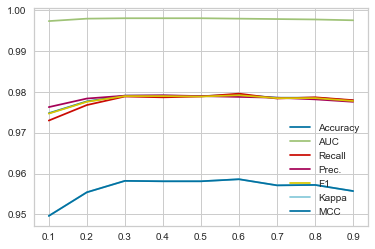

In [80]:
models = []
results = []

for i in np.arange(0.1,1,0.1):
    model = create_model('xgboost', cross_validation=True, learning_rate = i, verbose=False)
    model_results = pull().loc[['Mean']]
    models.append(model)
    results.append(model_results)
    
results = pd.concat(results, axis=0)
results.index = np.arange(0.1,1,0.1)
results.plot()

Tras la creación del modelo teniendo en cuenta su tasa de aprendizaje, se establece esta en 0.2.

In [81]:
results.style.highlight_max(color = 'et', axis = 0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0.100000,0.974800,0.997400,0.973000,0.976300,0.974700,0.949600,0.949600
0.200000,0.977700,0.998000,0.976800,0.978400,0.977600,0.955400,0.955400
0.300000,0.979100,0.998100,0.978900,0.979100,0.979000,0.958200,0.958200
0.400000,0.979100,0.998100,0.978700,0.979200,0.979000,0.958100,0.958100
0.500000,0.979000,0.998100,0.978900,0.979000,0.978900,0.958100,0.958100
0.600000,0.979300,0.998000,0.979600,0.978800,0.979200,0.958600,0.958600
0.700000,0.978600,0.997900,0.978400,0.978600,0.978500,0.957100,0.957100
0.800000,0.978600,0.997800,0.978700,0.978200,0.978500,0.957200,0.957200
0.900000,0.977900,0.997600,0.978000,0.977600,0.977800,0.955700,0.955700


In [82]:
model = create_model('xgboost', cross_validation=True, learning_rate = 0.5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9790,0.9980,0.9774,0.9804,0.9789,0.9579,0.9579
1,0.9803,0.9984,0.9797,0.9808,0.9802,0.9606,0.9606
2,0.9776,0.9978,0.9791,0.9764,0.9778,0.9553,0.9553
3,0.9807,0.9983,0.9806,0.9803,0.9805,0.9613,0.9613
4,0.9792,0.9981,0.9788,0.9792,0.9790,0.9585,0.9585
5,0.9774,0.9980,0.9786,0.9756,0.9771,0.9547,0.9547
6,0.9797,0.9981,0.9803,0.9791,0.9797,0.9594,0.9594
7,0.9768,0.9977,0.9739,0.9793,0.9766,0.9537,0.9537
8,0.9785,0.9980,0.9788,0.9781,0.9785,0.9570,0.9570


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

<h3><div style="font-size:14px; text-align:center"><b>AJUSTAR EL MODELO</b></div></h3>

In [83]:
model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=3, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

In [84]:
tuned_model = tune_model(model, optimize='Accuracy', n_iter=20, choose_better=True)  # , custom_grid=param_grid)
tuned_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9799,0.9985,0.9884,0.9716,0.9800,0.9597,0.9599
1,0.9784,0.9985,0.9881,0.9693,0.9786,0.9569,0.9571
2,0.9799,0.9984,0.9896,0.9709,0.9801,0.9597,0.9599
3,0.9798,0.9986,0.9903,0.9695,0.9798,0.9595,0.9598
4,0.9789,0.9983,0.9892,0.9687,0.9789,0.9578,0.9580
5,0.9783,0.9984,0.9883,0.9682,0.9782,0.9565,0.9567
6,0.9786,0.9984,0.9887,0.9692,0.9788,0.9572,0.9574
7,0.9788,0.9981,0.9871,0.9707,0.9788,0.9576,0.9577
8,0.9780,0.9982,0.9874,0.9691,0.9781,0.9560,0.9562


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=260, n_jobs=3, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

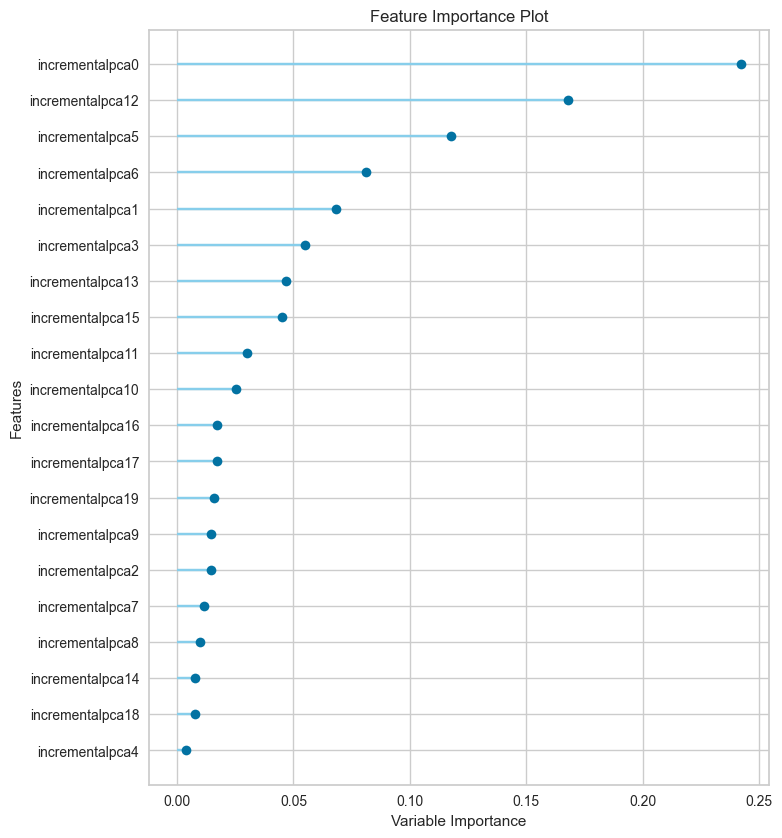

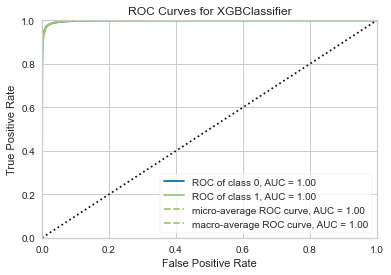

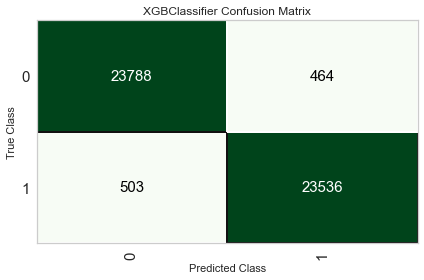

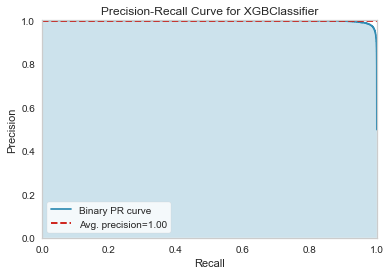

[None, None, None, None]

In [85]:
plots = ['feature_all', 'auc', 'confusion_matrix', 'pr']
list(map(lambda x: plot_model(model, plot=x), plots))

<h3><div style="font-size:14px; text-align:center"><b>FINALIZAR EL MODELO</b></div></h3>

Con el mejor de los modelos seleccionado y ajustado, se ajusta el modelo al conjunto de todos los datos, incluyendo test y train. Realizando finalmente una predicción sobre el conjunto de datos que se extrajo en un principio y no se han usado durante todo el proceso de creación del modelo.

In [86]:
final_model = finalize_model(tuned_model)
final_model

Pipeline(memory=FastMemory(location=C:\Users\NEURAP~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['c61', 'c62', 'c31', 'c56', 'c65'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorica...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               n_estimators=260, n_jobs=3,
                               num_parallel_tree=None,
                               objective='binary:logistic', predictor=None, ...))],
         verbose=False)

Ya con el modelo creado, pasamos a realizar las predicciones con los datos que se ha reservado para ello.

In [87]:
# Prediccion sobre el conjunto de test
predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9986,1.0000,0.9985,0.9987,0.9986,0.9971,0.9971


,c7,c10,c132,c141,c144,c151,c30,c31,c35,c106,...,c130,c84,c123,c51,c101,c109,c156,c1,prediction_label,prediction_score
72526,4.0,10.0,25.0,6.0,24.0,2.0,5.0,0.979928,969.0,0.0,...,4.0,10.0,1.0,11.0,13.0,1.0,3.0,1,1,1.0
32311,7.0,23.0,1.0,6.0,11.0,1.0,5.0,0.154111,2441.0,1.0,...,8.0,14.0,1.0,15.0,13.0,1.0,3.0,1,1,1.0
112077,10.0,23.0,0.0,6.0,1.0,0.0,5.0,0.555400,3354.0,2.0,...,4.0,10.0,0.0,11.0,8.0,1.0,9.0,1,1,1.0
46396,10.0,33.0,0.0,3.0,46.0,4.0,0.0,2.082174,3808.0,2.0,...,2.0,20.0,0.0,11.0,5.0,3.0,2.0,1,1,1.0
58036,8.0,18.0,25.0,6.0,23.0,1.0,5.0,0.393797,2377.0,2.0,...,8.0,16.0,1.0,11.0,11.0,1.0,3.0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,2.0,44.0,25.0,1.0,11.0,1.0,5.0,0.236432,1782.0,1.0,...,4.0,19.0,2.0,15.0,13.0,1.0,3.0,1,1,1.0
133743,0.0,33.0,1.0,1.0,11.0,1.0,5.0,0.538382,2441.0,0.0,...,4.0,19.0,1.0,15.0,13.0,1.0,3.0,1,1,1.0
110782,3.0,13.0,25.0,6.0,45.0,3.0,5.0,3.737920,1972.0,2.0,...,2.0,10.0,0.0,11.0,14.0,1.0,7.0,1,1,1.0
80213,8.0,10.0,1.0,7.0,11.0,1.0,5.0,0.088334,2513.0,2.0,...,4.0,19.0,2.0,15.0,12.0,1.0,3.0,1,1,1.0


In [88]:
# Predicción sobre el conjunto de datos unseen
predict_model(final_model, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9813,0.9986,0.9902,0.9727,0.9814,0.9626,0.9627


,c7,c10,c132,c141,c144,c151,c30,c31,c35,c106,...,c130,c84,c123,c51,c101,c109,c156,c1,prediction_label,prediction_score
0,0.0,33.0,25.0,6.0,11.0,1.0,5.0,0.083274,325.0,1.0,...,4.0,20.0,1.0,3.0,13.0,1.0,3.0,0,0,1.0000
1,0.0,33.0,1.0,4.0,23.0,1.0,5.0,0.095082,2485.0,1.0,...,6.0,20.0,2.0,9.0,13.0,3.0,3.0,0,0,1.0000
2,0.0,33.0,1.0,7.0,11.0,1.0,5.0,0.092074,1664.0,1.0,...,4.0,19.0,0.0,9.0,10.0,1.0,3.0,0,0,1.0000
3,0.0,29.0,1.0,6.0,46.0,4.0,5.0,0.335493,2355.0,1.0,...,2.0,20.0,0.0,11.0,12.0,1.0,3.0,0,0,0.9999
4,0.0,33.0,1.0,4.0,23.0,1.0,5.0,0.117683,1745.0,1.0,...,4.0,5.0,1.0,9.0,6.0,1.0,3.0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53652,0.0,10.0,25.0,1.0,11.0,1.0,5.0,0.778080,48.0,1.0,...,4.0,10.0,1.0,15.0,11.0,1.0,6.0,1,1,1.0000
53653,1.0,18.0,25.0,6.0,11.0,1.0,5.0,0.562218,1594.0,2.0,...,8.0,5.0,1.0,15.0,11.0,1.0,3.0,1,1,1.0000
53654,1.0,53.0,1.0,1.0,11.0,1.0,5.0,0.565689,2355.0,1.0,...,4.0,10.0,1.0,15.0,6.0,1.0,3.0,1,1,1.0000
53655,1.0,49.0,1.0,1.0,11.0,1.0,5.0,0.119438,2187.0,0.0,...,2.0,10.0,1.0,15.0,6.0,1.0,2.0,1,1,1.0000


<h3><div style="font-size:14px; text-align:center"><b>GUARDAR EL MODELO</b></div></h3>

Tras todo el proceso de modelado y ajuste del mismo, para poder utilizar el modelo en un entorno de producción, es necesario guardar el mismo. Para ello, se emplea las propias herramientas de PyCaret.

In [89]:
# Registrar la hora actual para el guardado del modelo
date = datetime.now()
date = date.strftime('%Y%m%d_%H%M')

# Guardado del modelo
model_name = 'crew_model'
save_model(final_model, f'{model_info_dir}{model_name}_{date}')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\NEURAP~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['c61', 'c62', 'c31', 'c56', 'c65'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorica...
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,

In [90]:
# CARGAR Y USAR EL MODELO

model_loaded = load_model(f'{model_info_dir}{model_name}_{date}')
new_prediction = predict_model(model_loaded, data=data_unseen)

Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9813,0.9986,0.9902,0.9727,0.9814,0.9626,0.9627
